Welcome to the cooltools command line interface (CLI) notebook!

Cooltools features a paired python API & CLI that enables user-facing functions to be run from the command line.

In [1]:
import os
import pandas as pd
import bioframe
import cooltools
import cooler
# We can use this function to display a file within the notebook
from IPython.display import Image


# download test data
# this file is 145 Mb, and may take a few seconds to download
cool_file = cooltools.download_data("HFF_MicroC", cache=True, data_dir='./data/')    
print(cool_file)

# To use this variable in a bash call from jupyter just use $cool_file

./data/test.mcool


In [2]:
%%bash
mkdir -p data
mkdir -p outputs

In [3]:
# Note for the correct bash environment to be recognized from jupyter with the ! magic,
# jupyter notebook must be initialized from a conda environment with cooler and cooltools installed.

To see a list of CLI commands for cooltools, see the help:

In [4]:
!cooltools -h

Usage: cooltools [OPTIONS] COMMAND [ARGS]...

  Type -h or --help after any subcommand for more information.

Options:
  -v, --verbose  Verbose logging
  -d, --debug    Post mortem debugging
  -V, --version  Show the version and exit.
  -h, --help     Show this message and exit.

Commands:
  dots            Call dots on a Hi-C heatmap that are not larger than...
  eigs-cis        Perform eigen value decomposition on a cooler matrix to...
  eigs-trans      Perform eigen value decomposition on a cooler matrix to...
  expected-cis    Calculate expected Hi-C signal for cis regions of...
  expected-trans  Calculate expected Hi-C signal for trans regions of...
  genome          Utilities for binned genome assemblies.
  insulation      Calculate the diamond insulation scores and call...
  pileup          Perform retrieval of the snippets from .cool file.
  random-sample   Pick a random sample of contacts from a Hi-C map, w/o...
  saddle          Calculate saddle statistics and generate saddle

## Visualization

In [5]:
!cooler show $cool_file::resolutions/1000000 'chr2' -o 'outputs/chr2.png'

  mat = np.log10(mat)



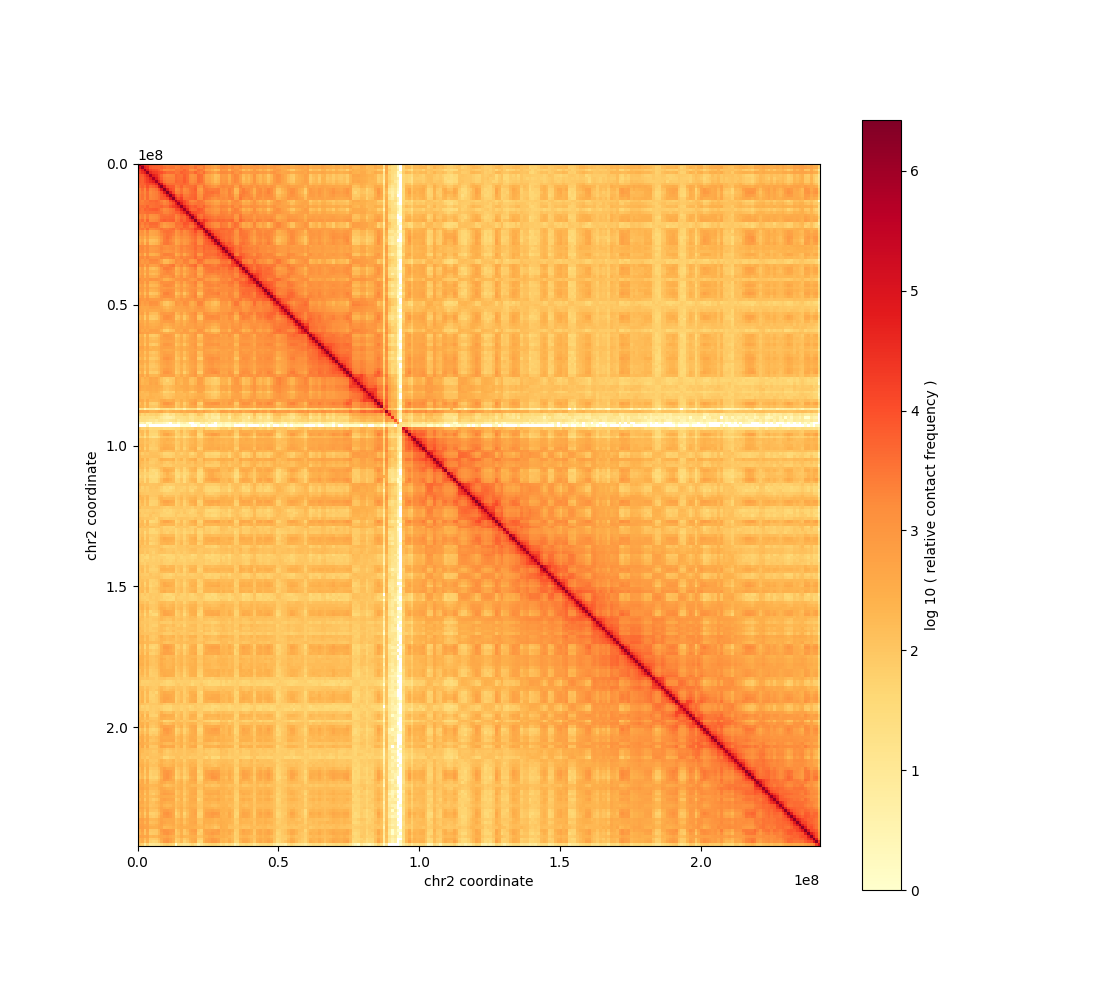

In [6]:
Image('outputs/chr2.png', width=400, height=400)

## Expected 

Tables of expected counts, either in cis or trans, are key inputs for many downstream analyses in cooltools.
For more details, see the [contacts_vs_dist](https://github.com/open2c/open2c_examples/blob/master/contacts_vs_distance.ipynb) notebook.

Typically, we specify a view to define regions under analysis. 
Here we quickly create a view that specifies chromosome arms using tables of chromosome sizes and centromere positions.

In [7]:
# create a view of hg38 chromosome arms using chromosome sizes and definition of centromeres
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
view_hg38 = bioframe.make_chromarms(hg38_chromsizes,  hg38_cens)

# select only those chromosomes available in cooler
clr = cooler.Cooler(f'{cool_file}::/resolutions/1000000')
view_hg38 = view_hg38[view_hg38.chrom.isin(clr.chromnames)].reset_index(drop=True)
view_hg38.to_csv("data/view_hg38.tsv", index=False, header=False, sep='\t')

In [8]:
! cooltools expected-cis $cool_file::resolutions/100000 --nproc 6 -o 'outputs/test.expected.cis.100000.tsv' --view "data/view_hg38.tsv"

Note expected for the first two distances are not defined with default settings, due to masking of near-diagonals in the cooler.

In [9]:
display(
    pd.read_table("outputs/test.expected.cis.100000.tsv")[0:5]
)

,region1,region2,dist,n_valid,count.sum,balanced.sum,count.avg,balanced.avg
0,chr2_p,chr2_p,0,878,NaN,NaN,NaN,NaN
1,chr2_p,chr2_p,1,876,NaN,NaN,NaN,NaN
2,chr2_p,chr2_p,2,874,2738583.0,65.287351,3133.390160,0.074699
3,chr2_p,chr2_p,3,872,1739972.0,41.011675,1995.380734,0.047032
4,chr2_p,chr2_p,4,870,1184707.0,28.473626,1361.732184,0.032728


## Compartments & saddles

Many contact maps display plaid patterns of interactions.
For more detail see the [compartments](https://github.com/open2c/open2c_examples/blob/master/compartments_and_saddles.ipynb) notebook. 

Since the orientation of eigenvectors is determined up to a sign, we often use GC content to orient or "phase" eigenvectors. Before calculating comparments, this notebook generates a binned GC content profile for the relevant region.

In [10]:
## fasta sequence is required for calculating binned profile of GC conent
if not os.path.isfile('./data/hg38.fa'):
    ## note downloading a ~1Gb file can take a minute
    subprocess.call('wget https://hgdownload.cse.ucsc.edu/goldenpath/hg38/bigZips/hg38.fa.gz', shell=True)
    subprocess.call('gunzip ./data/hg38.fa.gz', shell=True)

Bins can be fetched from the cooler, dropping any weights columns & keeping the header.

In [11]:
!cooler dump --header -t bins $cool_file::resolutions/100000 | cut -f1-3 > outputs/bins.100000.tsv

In [12]:
!cooltools genome gc outputs/bins.100000.tsv data/hg38.fa > outputs/gc.100000.tsv

In [13]:
!cooltools eigs-cis -o outputs/test.eigs.100000 --view data/view_hg38.tsv --phasing-track outputs/gc.100000.tsv --n-eigs 1 $cool_file::resolutions/100000

In [14]:
display(
    pd.read_table('outputs/test.eigs.100000.cis.vecs.tsv')[0:5]
)

,chrom,start,end,weight,E1
0,chr2,0,100000,0.006754,-1.564658
1,chr2,100000,200000,0.006767,-1.747567
2,chr2,200000,300000,0.004638,-0.370827
3,chr2,300000,400000,0.006034,-1.326894
4,chr2,400000,500000,0.006153,-1.434981


Pairwise class averaging is a typical way to reveal preferences in contact frequencies between
regions.

In [15]:
!cooltools saddle --qrange 0.02 0.98 --fig png -o outputs/test.saddle.cis.100000 --view data/view_hg38.tsv $cool_file::resolutions/100000 outputs/test.eigs.100000.cis.vecs.tsv outputs/test.expected.cis.100000.tsv 

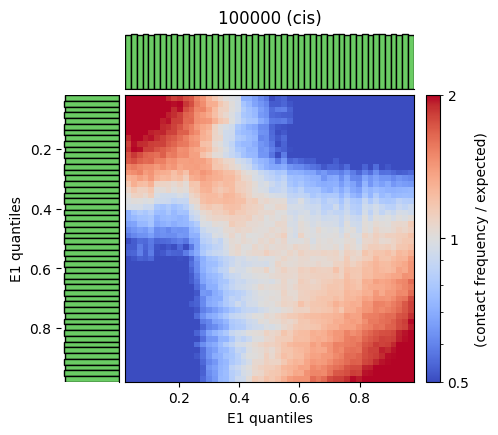

In [16]:
Image('outputs/test.saddle.cis.100000.png', width=400, height=400)

## Insulation & boundaries

A common strategy to summarize the near-diagonal structure of a contact map
is by computing insulation scores. See the [insulation](https://github.com/open2c/open2c_examples/blob/master/insulation_and_boundaries.ipynb) notebook for more details.

The command below uses the Li method to threshold the insulation score for boundary calling, so the resulting table has both log2 insulation scores and whether a given region is a boundary. The boundary_strength_{window} column has a value for all local minima of the insulation profile, and the is_boundary_{window} column indicates whether this strength passed the threshold. Note that {window} indicates the chosen size of the sliding diamond, and the command below uses windows of size 100kb and 200kb.

In [17]:
! cooltools insulation --threshold Li -o 'outputs/test.insulation.10000.tsv' --view "data/view_hg38.tsv" $cool_file::resolutions/10000 100000 200000

In [18]:
display(
    pd.read_table('outputs/test.insulation.10000.tsv')[0:5]
)

,chrom,start,end,region,is_bad_bin,log2_insulation_score_100000,n_valid_pixels_100000,log2_insulation_score_200000,n_valid_pixels_200000,boundary_strength_100000,boundary_strength_200000,is_boundary_100000,is_boundary_200000
0,chr2,0,10000,chr2_p,True,NaN,0.0,NaN,0.0,NaN,NaN,False,False
1,chr2,10000,20000,chr2_p,False,0.692051,8.0,1.123245,18.0,NaN,NaN,False,False
2,chr2,20000,30000,chr2_p,False,0.760561,17.0,1.196643,37.0,NaN,NaN,False,False
3,chr2,30000,40000,chr2_p,False,0.766698,27.0,1.211748,57.0,NaN,NaN,False,False
4,chr2,40000,50000,chr2_p,False,0.674906,37.0,1.135037,77.0,NaN,NaN,False,False


## Dots & focal enrichment

Punctate pairwise peaks of enriched contact frequency are a prevalent feature of mammalian interphase contact maps.  See the [dots](https://github.com/open2c/open2c_examples/blob/master/dots.ipynb) notebook for more details.

Since dots are evident at higher resolutions, we first calculate the 10kb expected, and we used multiple cores to speed up the calculation.

In [19]:
! cooltools expected-cis --nproc 6 -o 'outputs/test.expected.cis.10000.tsv' --view "data/view_hg38.tsv" $cool_file::resolutions/10000 

In [20]:
! cooltools dots --nproc 6 -o 'outputs/test.dots.10000.tsv' --view "data/view_hg38.tsv" $cool_file::resolutions/10000 outputs/test.expected.cis.10000.tsv 

INFO:root:Using recommended donut-based kernels with w=5, p=2 for binsize=10000
INFO:root: matrix 9314X9314 to be split into 256 tiles of 600X600.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root: matrix 14907X14907 to be split into 625 tiles of 600X600.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root: matrix 2472X2472 to be split into 25 tiles of 600X600.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root: matrix 5855X5855 to be split into 100 tiles of 600X600.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root:convolving 108 tiles to build histograms for lambda-bins
INFO:root:creating a Pool of 6 workers to tackle 108 tiles
/Users/geofffudenberg/anaconda3/envs/open2c/lib/python3.8/site-packages/cooltools/api/dotfinder.py:797: PerformanceWarning: indexing past lexsort depth may impact performance.
  expected_indexed.loc[region_name, region_name][

/Users/geofffudenberg/anaconda3/envs/open2c/lib/python3.8/site-packages/cooltools/api/dotfinder.py:797: PerformanceWarning: indexing past lexsort depth may impact performance.
  expected_indexed.loc[region_name, region_name][expected_value_col].to_numpy()
/Users/geofffudenberg/anaconda3/envs/open2c/lib/python3.8/site-packages/cooltools/api/dotfinder.py:797: PerformanceWarning: indexing past lexsort depth may impact performance.
  expected_indexed.loc[region_name, region_name][expected_value_col].to_numpy()
/Users/geofffudenberg/anaconda3/envs/open2c/lib/python3.8/site-packages/cooltools/api/dotfinder.py:797: PerformanceWarning: indexing past lexsort depth may impact performance.
  expected_indexed.loc[region_name, region_name][expected_value_col].to_numpy()
/Users/geofffudenberg/anaconda3/envs/open2c/lib/python3.8/site-packages/cooltools/api/dotfinder.py:797: PerformanceWarning: indexing past lexsort depth may impact performance.
  expected_indexed.loc[region_name, region_name][expecte

/Users/geofffudenberg/anaconda3/envs/open2c/lib/python3.8/site-packages/cooltools/api/dotfinder.py:797: PerformanceWarning: indexing past lexsort depth may impact performance.
  expected_indexed.loc[region_name, region_name][expected_value_col].to_numpy()
/Users/geofffudenberg/anaconda3/envs/open2c/lib/python3.8/site-packages/cooltools/api/dotfinder.py:797: PerformanceWarning: indexing past lexsort depth may impact performance.
  expected_indexed.loc[region_name, region_name][expected_value_col].to_numpy()
/Users/geofffudenberg/anaconda3/envs/open2c/lib/python3.8/site-packages/cooltools/api/dotfinder.py:797: PerformanceWarning: indexing past lexsort depth may impact performance.
  expected_indexed.loc[region_name, region_name][expected_value_col].to_numpy()
/Users/geofffudenberg/anaconda3/envs/open2c/lib/python3.8/site-packages/cooltools/api/dotfinder.py:797: PerformanceWarning: indexing past lexsort depth may impact performance.
  expected_indexed.loc[region_name, region_name][expecte

/Users/geofffudenberg/anaconda3/envs/open2c/lib/python3.8/site-packages/cooltools/api/dotfinder.py:797: PerformanceWarning: indexing past lexsort depth may impact performance.
  expected_indexed.loc[region_name, region_name][expected_value_col].to_numpy()
/Users/geofffudenberg/anaconda3/envs/open2c/lib/python3.8/site-packages/cooltools/api/dotfinder.py:797: PerformanceWarning: indexing past lexsort depth may impact performance.
  expected_indexed.loc[region_name, region_name][expected_value_col].to_numpy()
/Users/geofffudenberg/anaconda3/envs/open2c/lib/python3.8/site-packages/cooltools/api/dotfinder.py:797: PerformanceWarning: indexing past lexsort depth may impact performance.
  expected_indexed.loc[region_name, region_name][expected_value_col].to_numpy()
/Users/geofffudenberg/anaconda3/envs/open2c/lib/python3.8/site-packages/cooltools/api/dotfinder.py:797: PerformanceWarning: indexing past lexsort depth may impact performance.
  expected_indexed.loc[region_name, region_name][expecte

/Users/geofffudenberg/anaconda3/envs/open2c/lib/python3.8/site-packages/cooltools/api/dotfinder.py:797: PerformanceWarning: indexing past lexsort depth may impact performance.
  expected_indexed.loc[region_name, region_name][expected_value_col].to_numpy()
/Users/geofffudenberg/anaconda3/envs/open2c/lib/python3.8/site-packages/cooltools/api/dotfinder.py:797: PerformanceWarning: indexing past lexsort depth may impact performance.
  expected_indexed.loc[region_name, region_name][expected_value_col].to_numpy()
/Users/geofffudenberg/anaconda3/envs/open2c/lib/python3.8/site-packages/cooltools/api/dotfinder.py:797: PerformanceWarning: indexing past lexsort depth may impact performance.
  expected_indexed.loc[region_name, region_name][expected_value_col].to_numpy()
/Users/geofffudenberg/anaconda3/envs/open2c/lib/python3.8/site-packages/cooltools/api/dotfinder.py:797: PerformanceWarning: indexing past lexsort depth may impact performance.
  expected_indexed.loc[region_name, region_name][expecte

/Users/geofffudenberg/anaconda3/envs/open2c/lib/python3.8/site-packages/cooltools/api/dotfinder.py:797: PerformanceWarning: indexing past lexsort depth may impact performance.
  expected_indexed.loc[region_name, region_name][expected_value_col].to_numpy()
/Users/geofffudenberg/anaconda3/envs/open2c/lib/python3.8/site-packages/cooltools/api/dotfinder.py:797: PerformanceWarning: indexing past lexsort depth may impact performance.
  expected_indexed.loc[region_name, region_name][expected_value_col].to_numpy()
/Users/geofffudenberg/anaconda3/envs/open2c/lib/python3.8/site-packages/cooltools/api/dotfinder.py:797: PerformanceWarning: indexing past lexsort depth may impact performance.
  expected_indexed.loc[region_name, region_name][expected_value_col].to_numpy()
/Users/geofffudenberg/anaconda3/envs/open2c/lib/python3.8/site-packages/cooltools/api/dotfinder.py:797: PerformanceWarning: indexing past lexsort depth may impact performance.
  expected_indexed.loc[region_name, region_name][expecte

/Users/geofffudenberg/anaconda3/envs/open2c/lib/python3.8/site-packages/cooltools/api/dotfinder.py:797: PerformanceWarning: indexing past lexsort depth may impact performance.
  expected_indexed.loc[region_name, region_name][expected_value_col].to_numpy()
/Users/geofffudenberg/anaconda3/envs/open2c/lib/python3.8/site-packages/cooltools/api/dotfinder.py:797: PerformanceWarning: indexing past lexsort depth may impact performance.
  expected_indexed.loc[region_name, region_name][expected_value_col].to_numpy()
/Users/geofffudenberg/anaconda3/envs/open2c/lib/python3.8/site-packages/cooltools/api/dotfinder.py:797: PerformanceWarning: indexing past lexsort depth may impact performance.
  expected_indexed.loc[region_name, region_name][expected_value_col].to_numpy()
/Users/geofffudenberg/anaconda3/envs/open2c/lib/python3.8/site-packages/cooltools/api/dotfinder.py:797: PerformanceWarning: indexing past lexsort depth may impact performance.
  expected_indexed.loc[region_name, region_name][expecte

In [21]:
display(
    pd.read_table('outputs/test.dots.10000.tsv')[0:5]
)

,chrom1,start1,end1,weight1,chrom2,start2,end2,weight2,bin1_id,bin2_id,...,la_exp.vertical.qval,la_exp.horizontal.qval,la_exp.lowleft.qval,region,cstart1,cstart2,c_label,c_size,region1,region2
0,chr17,12250000,12260000,0.006993,chr17,12740000,12750000,0.010509,25445,25494,...,2.210430e-22,2.032096e-22,1.506741e-33,chr17_p,1.220571e+07,1.273857e+07,0,7,chr17_p,chr17_p
1,chr17,10640000,10650000,0.009687,chr17,11980000,11990000,0.010589,25284,25418,...,1.368050e-08,1.294897e-08,8.847705e-09,chr17_p,1.063000e+07,1.195500e+07,1,4,chr17_p,chr17_p
2,chr17,9920000,9930000,0.009252,chr17,10610000,10620000,0.007656,25212,25281,...,3.310219e-171,7.071107e-246,2.515747e-246,chr17_p,9.920000e+06,1.061200e+07,2,4,chr17_p,chr17_p
3,chr17,10640000,10650000,0.009687,chr17,10840000,10850000,0.009434,25284,25304,...,2.637572e-154,1.768044e-154,4.524004e-183,chr17_p,1.063667e+07,1.083889e+07,3,9,chr17_p,chr17_p
4,chr17,12180000,12190000,0.010278,chr17,13000000,13010000,0.011248,25438,25520,...,7.841810e-80,1.045765e-79,7.967002e-80,chr17_p,1.218571e+07,1.299143e+07,4,7,chr17_p,chr17_p


## Pileups & average features

A common method for quantifying contact maps is by creating pileup plots, which are averages over a set of "snippets", or 2D windows, from the genome-wide map. See the [pileups](https://github.com/open2c/open2c_examples/blob/master/pileup_CTCF.ipynb) notebook for more details.

Below shows pileup for dots that were computed above.


In [22]:
#TODO after https://github.com/open2c/cooltools/issues/395
#!cooltools pileup --features-format BEDPE --nproc 6 -o 'outputs/test.pileup.10000.npz' --view "data/view_hg38.tsv" --expected outputs/test.expected.cis.10000.tsv $cool_file::resolutions/10000 <(tail -n+2 outputs/test.dots.10000.tsv) 